# What is a Bayes net?

A Bayes net is a probabilistic graphical model, or PGM. It is a simple and intuitive way to represent a joint probability distribution that allows us to encode dependencies between the variables we are trying to model.

A Bayes net can be used to represent both discrete and continuous valued variables. Initially we will look at discrete binary variables, and then add layers to the modelling for more complex networks.

Bayes nets are used for different purposes. They can be simulated directly, so as to generate instances of the joint probability distributions. They can also be used for inference; that is, given an observation....





# Representing a Bayes net

Conceptually a Bayes net is simple; all we need is the node mappings, or dependencies, and the probabilities that define the conditional / unconditional probability distributions. In terms of defining a structure, we can use a namedtuple to define the following attributes:
- name: maps a convenient shorthand node label to the to the full text
- deps: dependencies that map nodes to their dependencies
- probs: probabilities at node variables, to be defined later
- ind_nodes: independent nodes with no dependencies

The _ind_nodes_ attributes is useful for being able to iterate through the net. This can be initialised to None and then calculated. It could also be supplied explicitly, but that's unlikely to be feasible for larger problems.

In terms of examples we'll look at two.

1. The alarm network: https://github.com/jpmcarrilho/AIMA/blob/master/probability-4e.ipynb 
    _The story, from Judea Pearl, is that there is a house burglar alarm, which can be triggered by either a burglary or an earthquake. If the alarm sounds, one or both of the neighbors, John and Mary, might call the owwner to say the alarm is sounding._

2. This one also looked fun! https://www.cs.cmu.edu/afs/cs.cmu.edu/project/learn-43/lib/photoz/.g/web/glossary/bayesnet.html

In [1]:
from collections import namedtuple

BayesNet = namedtuple('BayesNet', 'names deps probs ind_nodes')

In [2]:
bayesnet_alarm = BayesNet(names = {'B' : 'Burglary',
                                   'E' : 'Earthquake',
                                   'A' : 'Alarm',
                                   'M' : 'Mary calls',
                                   'J' : 'John calls'},
                          deps = {'B' : ['A'],
                                  'E' : ['A'],
                                  'A' : ['M', 'J']},
                          probs = None,
                          ind_nodes = None)

bayesnet_mars_medical = BayesNet(names = {'V' : 'Visited Mars',
                                          'C' : 'Common cold',
                                          'M' : 'Martian death flu',
                                          'R' : 'Runny nose',
                                          'H' : 'Headache',
                                          'S' : 'Spontaneous combustion'},
                                 deps = {'V' : ['M'],
                                         'M' : ['R', 'H', 'S'],
                                         'C' : ['R', 'H']},
                                 probs = None,
                                 ind_nodes = None)

## Extract info and add to Bayes net

Before proceeding we define a function to extract the independent nodes, as implied from the dependencies, and update the Bayes nets we defined.

In [3]:
def add_ind_nodes(bn):
    all_nodes_with_parents = set([nn for nns in bn.deps.values() for nn in nns])
    ind_nodes = [n for n in bn.deps.keys() if n not in all_nodes_with_parents]
    return BayesNet(names = bn.names,
                    deps = bn.deps,
                    probs = bn.probs,
                    ind_nodes = ind_nodes)  
    
bayesnet_alarm = add_ind_nodes(bayesnet_alarm)
bayesnet_mars_medical = add_ind_nodes(bayesnet_mars_medical)

# check as expected - sort since no ordering on dictionary keys
assert (sorted(bayesnet_alarm.ind_nodes) == ['B', 'E'])
assert (sorted(bayesnet_mars_medical.ind_nodes) == ['C', 'V'])

## Visualise the Bayes net

Define a function to visualise the Bayes net and try it on the two examples.

In [4]:
import graphviz

def visualise_bn(bn, names=True):
    g = graphviz.Digraph()
    for node, next_nodes in bn.deps.items():
        for nn in next_nodes:
            if names:
                g.edge(bn.names[node], bn.names[nn])
            else:
                g.edge(node, nn)
    return g

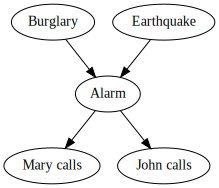

In [5]:
visualise_bn(bayesnet_alarm)

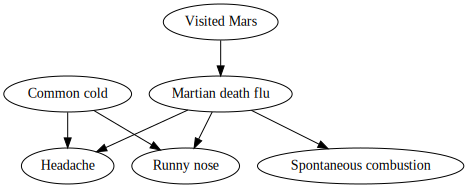

In [6]:
visualise_bn(bayesnet_mars_medical)

## Iterate through the Bayes net

If we want to simulate the Bayes net, we'll need to be able to iterate through it in some way. The function below does this using the approach of maintaining a frontier of states to be explored, and a set of states that have already been explored. The initial frontier is the set of indepedent nodes in the net. As each node is explored its dependencies are added to the frontier, and subsequently explored. 

For simulation purposes we would want the exploration to be depth-first, since a given node would require all of its parent nodes to be evaluated before we could pick out the conditional probability distribution from which to sample.

In [7]:
import pdb
def iterate_bn(bn):
    explored = set(bn.ind_nodes.copy())
    frontier = bn.ind_nodes.copy() # otherwise overwrites attribute
    while frontier:
        node = frontier.pop()        
        next_nodes = bn.deps[node] if node in bn.deps.keys() else []
        print(f'at node {node}')
        for nn in next_nodes:
            if nn not in explored:
                print(f'    adding {nn}')
                frontier.insert(0, nn) # queue structure for dfs
                explored.add(nn)

Try this on the two nets. 

In [8]:
print('iterate through alarm net')
iterate_bn(bayesnet_alarm)

print('\niterate through mars medical net')
iterate_bn(bayesnet_mars_medical)

iterate through alarm net
at node E
    adding A
at node B
at node A
    adding M
    adding J
at node M
at node J

iterate through mars medical net
at node C
    adding R
    adding H
at node V
    adding M
at node R
at node H
at node M
    adding S
at node S


# Adding probabilities

Though conceptually simple, Bayes nets can encode a complex joint probability distribution. To this end, we need to specify the conditional probability distribution at each node (or unconditional for independent nodes). The table below sets out a concise view for the alarm network. This is saved in the local file probs_alarm.csv.

This contains the minimal information we need to specify the _probs_ attribute of our _BayesNet_ structure. The general idea is to parse this into an equivalent data structure in Python, as opposed to coding the probabilities directly. The main advantage in this approach is that we can leave it to the user (not necessarily a coder) to specify the input in an intuitve way. The parse functions can also output useful information in the case that the input is not valid. 

In [44]:
import pandas as pd
df_probs_alarm = pd.read_csv('probs_alarm.csv')
df_probs_alarm

,node,value,conditionals,prob
0,B,T,None,0.001
1,E,T,None,0.002
2,A,T,B=T;E=T,0.950
3,A,T,B=T;E=F,0.940
4,A,T,B=F;E=T,0.290
5,A,T,B=F;E=F,0.001
6,J,T,A=T,0.900
7,J,T,A=F,0.050
8,M,T,A=T,0.700
9,M,T,A=F,0.010


## Add complentary probabilities
From the perspective of a user, we want to be able to specify the minimal information that is needed, as set out above. From the persective of checking that the input is valid, it is useful to have a complete view; for the input set out above, that means we would like to add, explicitly, the complementary rows that represent the _node=F_ events.

The function below does this by copying and appending _event=T_ rows, then sorting the table so that complementary events are listed together (not essential but useful in respect of being human-readable).

In [45]:
def add_complementary_probs_binary_discrete(df_probs):
    """
    input: dataframe with rows that represent event=T
    output: dataframe appended with complementary event=F rows
    """
    df_probs_compl = df_probs[df_probs.value == 'T']
    df_probs_compl.value = 'F'
    df_probs_compl.prob = 1 - df_probs_compl.prob
    df_probs = df_probs.append(df_probs_compl).sort_values(by=['node', 'conditionals']).reset_index(drop=True)
    
    return df_probs
    
df_probs_alarm = add_complementary_probs_binary_discrete(df_probs_alarm)
df_probs_alarm

,node,value,conditionals,prob
0,A,T,B=F;E=F,0.001
1,A,F,B=F;E=F,0.999
2,A,T,B=F;E=T,0.290
3,A,F,B=F;E=T,0.710
4,A,T,B=T;E=F,0.940
5,A,F,B=T;E=F,0.060
6,A,T,B=T;E=T,0.950
7,A,F,B=T;E=T,0.050
8,B,T,None,0.001
9,B,F,None,0.999


## Check that the probability input is valid

This is mostly common sense, and if we can outline the logic, we can then encode those checks within the parsing functions that convert the CSV input to an equivalent Python data structure.

We start with a given Bayes net that is in effect a schema against which to validate. We can split the checks into high-level checks and per-node ones as below.

_High-level_
- All probabilities lie between zero and one
- The unique set of nodes is consistent with the Bayes net
- Conditionals are either None or a semi-colon separated list of _node=value_ pairs

_Per node_
- If the node is independent, as specified in the Bayes net, then
    - all the corresponding rows have _conditionals=None_
    - all of the possible values are listed
    - the probabilities sum to one
- If the node is dependent, as specified in the Bayes net, then
    - all the corresponding rows do not have _conditionals=None_
    - all enumerations of the parent nodes are listed as separate rows e.g. TT, TF, FT, FF for a node with two binary parents
    - all of the possible values are listed, per enumeration of the parent nodes
    - the probabilities sum to one, per enumeration of the parent nodes
  

In [100]:
def validate_probs(df_probs, bn):
    # high-level
    #     All probabilities lie between zero and one
    #     The unique set of nodes is consistent with the Bayes net
    #     Conditionals are either None or a semi-colon separated list of node=value pairs
    assert all(df_probs['prob'] >= 0)
    assert all(df_probs['prob'] <= 1)
    assert sorted(list(set(df_probs['node']))) == sorted(list(bn.names.keys()))
    csv_list_dep_nodes = ','.join(bn.deps.keys())
    assert all(df_probs.conditionals.str.match(f'None|([{csv_list_dep_nodes}]=.*)(;[{csv_list_dep_nodes}]=.*)*'))
    print('high-level checks ok')

    # per node
    # If the node is independent, as specified in the Bayes net, then
    #     all the corresponding rows have _conditionals=None_
    #     all of the possible values are listed
    #     the probabilities sum to one
    # If the node is dependent, as specified in the Bayes net, then
    #     all the corresponding rows do not have _conditionals=None_
    #     all enumerations of the parent nodes are listed as separate rows e.g. TT, TF, FT, FF for a node with two binary parents
    #     all of the possible values are listed, per enumeration of the parent nodes
    #     the probabilities sum to one, per enumeration of the parent nodes
    
    
    
    
    print('per node checks ok')
    
    
validate_probs(df_probs_alarm, bayesnet_alarm)    



high-level checks ok
per node checks ok


False

In [54]:
def parse_conditionals(conditional):
    if conditional == 'None':
        return None
    
    cond_nodes = {}
    parent_node_value_pairs = [x.split('=') for x in conditional.split(';')]
    for parent_node_value in parent_node_value_pairs:
        parent_node = parent_node_value[0]
        value = parent_node_value[1]
        cond_nodes[parent_node] = value
    
    return cond_nodes

[parse_conditionals(cond) for cond in df_probs_alarm['conditionals']]


[{'B': 'F', 'E': 'F'},
 {'B': 'F', 'E': 'F'},
 {'B': 'F', 'E': 'T'},
 {'B': 'F', 'E': 'T'},
 {'B': 'T', 'E': 'F'},
 {'B': 'T', 'E': 'F'},
 {'B': 'T', 'E': 'T'},
 {'B': 'T', 'E': 'T'},
 None,
 None,
 None,
 None,
 {'A': 'F'},
 {'A': 'F'},
 {'A': 'T'},
 {'A': 'T'},
 {'A': 'F'},
 {'A': 'F'},
 {'A': 'T'},
 {'A': 'T'}]

# Simulating a Bayes net

In [102]:
def simulate_bn(bn):
    explored = set(bn.ind_nodes.copy())
    frontier = bn.ind_nodes.copy() # otherwise overwrites attribute
    while frontier:
        
        # pop node and simulate
        node = frontier.pop()  
        
        # add next nodes to frontier and explored, if not already explored
        next_nodes = bn.deps[node] if node in bn.deps.keys() else []
        print(f'at node {node}')
        for nn in next_nodes:
            if nn not in explored:
                print(f'    adding {nn}')
                frontier.insert(0, nn) # queue structure for dfs
                explored.add(nn)
                
                
                
                
simulate_bn(bayesnet_alarm)

at node E
    adding A
at node B
at node A
    adding M
    adding J
at node M
at node J
